# This notebook (Update 12.14)
* Try three different collaborative filterings: Memory, SVD, NMF
* Explore SVD performance with different n_components

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix, vstack
import pickle

## Load the data and convert into sparse matrix

In [334]:
def read_data(file_path):
    from scipy.sparse import csr_matrix
    
    # Read pickle
    stu = pd.read_pickle(file_path)
    
    # Num of dictionaries in the file
    n = len(stu)
    
    # Initialize df
    df = pd.DataFrame()
    
    # Loop through dicts and concat
    for i in range(n):
        stu[i]['student_id'] = i
        df = pd.concat([df,stu[i]])
    
    # df = user dataset we have
    # user_input: courses that user provide

    # Fix .0 issues -- Some courses has .0 at the end (e.g. AAS 101.0), remove .0
    df.loc[df['Subject/Catalog'].str.contains('\.') == True, 'Subject/Catalog'] = df.loc[df['Subject/Catalog'].str.contains('\.') == True, 'Subject/Catalog'].str.split('\.').str[0]
    
    # Pivot table to stu - course
    df = pd.pivot_table(df, values = 'Rating', index = 'student_id', columns = 'Subject/Catalog')
    
    # Fillna
    df = df.fillna(0)
    
    # df to sparse matrix
    csr = csr_matrix(df)
    
    # Store course names
    courses = list(df.columns)
    

    return csr, courses 

In [ ]:
#csr, courses = read_data('user_profiles.pickle')

### Store user profile csr and the list of courses

In [371]:
with open('csr.pkl', "wb") as fOut:
    pickle.dump(csr, fOut, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('courses.pkl', "wb") as fOut:
    pickle.dump(courses, fOut, protocol=pickle.HIGHEST_PROTOCOL)

### Load csr and courses

In [2]:
with open('csr.pkl', "rb") as fIn:
    csr = pickle.load(fIn)
with open('courses.pkl', "rb") as fIn:
     courses = pickle.load(fIn)

In [7]:
# random user input
user_input = np.random.choice(courses, size = 10, replace = False)

## Matrix-based collaborative filtering

In [28]:
from sklearn.decomposition import TruncatedSVD

def svd_based(csr, courses, user_input, num_factors = 100, top_n = 10, random_state=42):
    # SVD based collaborative filtering
    user_row = np.isin(courses, user_input)
    uc_mat = vstack([csr, user_row]).tocsr()
    
    user_idx = -1

    
    # SVD
    svd = TruncatedSVD(n_components = num_factors, random_state = random_state)
    
    # Transform X
    X_transformed = svd.fit_transform(uc_mat)
    
    # Calculate r
    r = np.matmul(X_transformed, svd.components_)
    
    # Pred rating
    pred_rating = r[user_idx,:]#.reshape(1,-1)
    
    
    # Matched user vector
    user_vec = uc_mat[user_idx].toarray().flatten()
    
    
    # User's favorite course indices
    user_fav_idx = np.argsort(-user_vec)
    
    # User's favorite courses
    #user_fav = [courses[i] for i in user_fav_idx[:top_n]]
    #print(f"Top {top_n} favorite courses:")
    #print(user_fav)

    
    # Flatten pred_rating
    pred_rating = np.asarray(pred_rating).flatten()
    
    # Argsort the rating except the courses taken by the user
    recommend_index = np.argsort(-pred_rating[user_vec == 0])
    
    # Recommend top courses
    top_courses = [courses[i] for i in recommend_index[:top_n]]

    # RMSE between true & predicted. Uncomment the next two lines to see RMSE
    rmse = np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2))
    #print(f"RMSE = {rmse}")
    
    return top_courses, rmse



-----------------
 

### RMSE & Runtime

In [19]:
r_list = []
for _ in range(100):
    user_input = np.random.choice(courses, size = 10, replace = False)
    pred, rmse = svd_based(csr, courses, user_input, num_factors = 200)
    r_list.append(rmse)
print(np.average(r_list))

3.0573910606197363


In [18]:
%%timeit
user_input = np.random.choice(courses, size = 10, replace = False)
pred, rmse = svd_based(csr, courses, user_input, num_factors = 200)

982 ms ± 33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
subcat = df['Subject/Catalog'].unique()

In [218]:
import numpy as np
def svd_tune(df, num_factors, top_n = 10, random_state=42):
    # SVD based collaborative filtering
    
    # user_idx = -1
    user_idx = -1
    rmse_list = []
    for i in range(100):
        user_input = np.random.choice(courses, size = 10, replace = False)
        uc_mat, courses = concat_user_input_and_convert_to_csr(df, user_input)

        # SVD
        svd = TruncatedSVD(n_components = num_factors, random_state = random_state)

        # Transform X
        X_transformed = svd.fit_transform(uc_mat)

        # Calculate r
        r = np.matmul(X_transformed, svd.components_)

        # Pred rating
        pred_rating = r[user_idx,:]#.reshape(1,-1)


        # Matched user vector
        user_vec = uc_mat[user_idx].toarray().flatten()


        # User's favorite course indices
        user_fav_idx = np.argsort(-user_vec)

        # User's favorite courses
        #user_fav = [courses[i] for i in user_fav_idx[:top_n]]
        #print(f"Top {top_n} favorite courses:")
        #print(user_fav)


        # Flatten pred_rating
        pred_rating = np.asarray(pred_rating).flatten()

        # Argsort the rating except the courses taken by the user
        recommend_index = np.argsort(-pred_rating[user_vec == 0])

        # Recommend top courses
        top_courses = [courses[i] for i in recommend_index[:top_n]]


        # RMSE between true & predicted. Uncomment the next two lines to see RMSE
        rmse_list.append(np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2)))
    avg_rmse = np.average(rmse_list)
    #print(f"RMSE = {avg_rmse}")
    
    return avg_rmse

-------------

### SVD runtime by n_components 

In [380]:
def svd_time(csr, num_factors, top_n = 10, random_state=42):
    # SVD based collaborative filtering
    
    # user_idx = -1
    user_idx = -1
    rmse_list = []
    for i in range(10):
        user_input = np.random.choice(courses, size = 10, replace = False)

        user_row = np.isin(courses, user_input)
        uc_mat = vstack([csr, user_row]).tocsr()

        user_idx = -1

        # SVD
        svd = TruncatedSVD(n_components = num_factors, random_state = random_state)

        # Transform X
        X_transformed = svd.fit_transform(uc_mat)

        # Calculate r
        r = np.matmul(X_transformed, svd.components_)

        # Pred rating
        pred_rating = r[user_idx,:]#.reshape(1,-1)


        # Matched user vector
        user_vec = uc_mat[user_idx].toarray().flatten()


        # User's favorite course indices
        user_fav_idx = np.argsort(-user_vec)

        # User's favorite courses
        #user_fav = [courses[i] for i in user_fav_idx[:top_n]]
        #print(f"Top {top_n} favorite courses:")
        #print(user_fav)


        # Flatten pred_rating
        pred_rating = np.asarray(pred_rating).flatten()

        # Argsort the rating except the courses taken by the user
        recommend_index = np.argsort(-pred_rating[user_vec == 0])

        # Recommend top courses
        top_courses = [courses[i] for i in recommend_index[:top_n]]

    
    return None

In [382]:
import time
x = np.arange(20, 220, 20)
runtime_list = []
for num in x:
    start = time.process_time()
    pred = svd_time(csr, num)   
    runtime = (time.process_time() - start)
    runtime_list.append(runtime/10)
    print(runtime/10)

0.6684559000001172
0.8825028999999631
1.0712218000000575
1.2470687000000908
1.401203600000008
1.6075128999997106
1.8312066999998933
2.0562102999996568
2.266528200000175


In [35]:
%%timeit
svd_based(csr, courses, user_input, num_factors = 20)

258 ms ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit
svd_based(csr, courses, user_input, num_factors = 60)

504 ms ± 97.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
svd_based(csr, courses, user_input, num_factors = 100)

574 ms ± 65.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%%timeit
svd_based(csr, courses, user_input, num_factors = 140)

797 ms ± 86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit
svd_based(csr, courses, user_input, num_factors = 180)

1.11 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit
svd_based(csr, courses, user_input, num_factors = 220)

1.25 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Plot - time by n_components

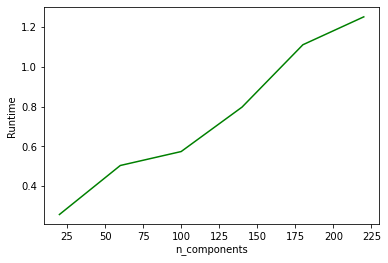

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

runtime_list -= 0.45 #adjusting the difference between runtime and %%timeit

x = np.arange(20, 260, 40)
runtime_list = [0.258, 0.504, 0.574, 0.797, 1.11, 1.25]

fig, ax1 = plt.subplots()

ax1.plot(x, runtime_list, color = 'green')
ax1.set_ylabel('Runtime')
ax1.set_xlabel('n_components')

plt.show()

## Explained Variance

In [108]:
import numpy as np
def svd_var(df, num_factors, top_n = 10, random_state=42):
    # SVD based collaborative filtering
    
    # user_idx = -1
    user_idx = -1
    explained_variance_list = []
    rmse_list = []
    for i in range(100):
        user_input = np.random.choice(courses, size = 10, replace = False)
        uc_mat, courses = concat_user_input_and_convert_to_csr(df, user_input)

        # SVD
        svd = TruncatedSVD(n_components = num_factors, random_state = random_state)

        # Transform X
        X_transformed = svd.fit_transform(uc_mat)

        # Calculate r
        r = np.matmul(X_transformed, svd.components_)

        # Pred rating
        pred_rating = r[user_idx,:]#.reshape(1,-1)


        # Matched user vector
        user_vec = uc_mat[user_idx].toarray().flatten()


        # User's favorite course indices
        user_fav_idx = np.argsort(-user_vec)

        # User's favorite courses
        #user_fav = [courses[i] for i in user_fav_idx[:top_n]]
        #print(f"Top {top_n} favorite courses:")
        #print(user_fav)


        # Flatten pred_rating
        pred_rating = np.asarray(pred_rating).flatten()

        # Argsort the rating except the courses taken by the user
        recommend_index = np.argsort(-pred_rating[user_vec == 0])

        # Recommend top courses
        top_courses = [courses[i] for i in recommend_index[:top_n]]


        # RMSE between true & predicted. 
        rmse_list.append(np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2)))
        
        # Explained variance 
        explained_variance_list.append(svd.explained_variance_ratio_.sum())
    
    avg_ev = np.average(explained_variance_list)
    avg_rmse = np.average(rmse_list)

    
    return avg_ev, avg_rmse

In [109]:
n = np.arange(50, 500, 50)
avg_ev_list = []
avg_rmse_list = []
for num in n:
    avg_ev, avg_rmse = svd_var(df, num, top_n = 10, random_state=42)
    avg_ev_list.append(avg_ev)
    avg_rmse_list.append(avg_rmse)
    #print("n_components: ",num, " Explained variance sum: ", avg_ev, ' RMSE: ', avg_rmse)
    

n_components:  50  Explained variance sum:  0.2069566432419802  RMSE:  3.136881940437139
n_components:  100  Explained variance sum:  0.3080865954789482  RMSE:  3.1243334888200214
n_components:  150  Explained variance sum:  0.37026838778355925  RMSE:  3.048886230162509
n_components:  200  Explained variance sum:  0.41887893620543243  RMSE:  3.0507622788673108
n_components:  250  Explained variance sum:  0.4610223165101213  RMSE:  3.0041577221473976
n_components:  300  Explained variance sum:  0.4989714855659057  RMSE:  2.9756654305757753
n_components:  350  Explained variance sum:  0.5332084669994797  RMSE:  2.932978723556314
n_components:  400  Explained variance sum:  0.5642925077415119  RMSE:  2.8732756662024808
n_components:  450  Explained variance sum:  0.592669329422925  RMSE:  2.8446796399219165


In [110]:
n = np.arange(500, 800, 50)
for num in n:
    avg_ev, avg_rmse = svd_var(df, num, top_n = 10, random_state=42)
    avg_ev_list.append(avg_ev)
    avg_rmse_list.append(avg_rmse)
    #print("n_components: ",num, " Explained variance sum: ", avg_ev, ' RMSE: ', avg_rmse)
    

n_components:  500  Explained variance sum:  0.6187698018564972  RMSE:  2.8370689935019273
n_components:  550  Explained variance sum:  0.642819555062698  RMSE:  2.756939016177228
n_components:  600  Explained variance sum:  0.6654379541743018  RMSE:  2.7701917618079115
n_components:  650  Explained variance sum:  0.6865863661990289  RMSE:  2.6958564337227897
n_components:  700  Explained variance sum:  0.706502879828708  RMSE:  2.7041602167885803
n_components:  750  Explained variance sum:  0.7252492577436896  RMSE:  2.6473528552518335


### Explained variance goes up and RMSE goes down as n_components gets higher. 

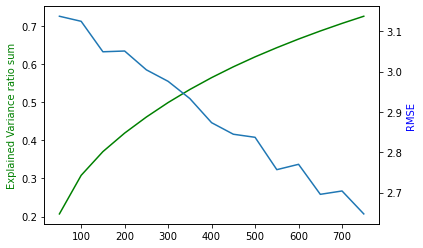

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax1 = plt.subplots()

x = np.arange(50, 800, 50)
ax1.plot(x, avg_ev_list, color = 'green')
ax1.set_ylabel('Explained Variance ratio sum', color = 'green')
ax2 = ax1.twinx()
ax2.plot(x, avg_rmse_list)
ax2.set_ylabel('RMSE', color = 'blue')
plt.show()

----------

## Memory-based collaborative filtering

In [12]:
import scipy.sparse
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def memory_based(csr, courses, user_input, top_n):
    # Memory-based collaborative filtering
    user_idx = -1
    
    user_row = np.isin(courses, user_input)
    uc_mat = vstack([csr, user_row]).tocsr()
    # Normalize user-course matrix
    norm_uc_mat = uc_mat - uc_mat.mean(axis = 1).reshape(-1,1)
    
    # Cosine similarity of raw matrix
    cossim = cosine_similarity(uc_mat)
    
    # Calculate the numerator of V-hat(aj)
    v_num = np.dot(cossim[user_idx,:], norm_uc_mat)
    
    # Sum of V-hat(aj) numerator
    v_num_sum = v_num.sum(axis = 0)
    
    # V_hat(aj)
    v_hat = v_num_sum/(cossim[user_idx,:].sum())
    
    #Predicted rating of each course
    pred_rating = np.add(v_hat, uc_mat.mean(axis = 1).reshape(-1,1)[user_idx])
    
    # User vector
    user_vec = uc_mat[user_idx].toarray().flatten()
    
    # User's favorite course indices
    user_fav_idx = np.argsort(-user_vec)
    
    # User's favorite courses
    user_fav = [courses[i] for i in user_fav_idx[:top_n]]
    #print(f"Top {top_n} favorite courses:")
    #print(user_fav)
    
    # Flatten pred_rating
    pred_rating = np.asarray(pred_rating).flatten()
    
    
    # Argsort the rating except the courses taken by the user
    recommend_index = np.argsort(-pred_rating[user_vec == 0])
    
    # Recommend top courses
    top_courses = [courses[i] for i in recommend_index[:top_n]]
    
    #print(f"Top {top_n} recommended courses:")
    #print(top_courses)

    #print()

    # RMSE between true & predicted
    rmse = np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2))
    #print(f"RMSE = {rmse}")
    
    return top_courses, rmse



In [13]:
%%timeit
user_input = np.random.choice(courses, size = 10, replace = False)
pred = memory_based(csr, courses, user_input, 10)

1.17 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
r_list = []

for _ in range(100):
    user_input = np.random.choice(courses, size = 10, replace = False)
    pred, rmse = memory_based(csr, courses, user_input, 10)
    r_list.append(rmse)
print(np.average(r_list))

2.3113030911012737


## NMF-based collaborative filtering

In [363]:
from sklearn.decomposition import NMF

def nmf_based(uc_mat, courses, user_input, num_factors = 80, top_n = 10, random_state=42):
    # NMF based collaborative filtering
    user_row = np.isin(courses, user_input)
    uc_mat = vstack([csr, user_row]).tocsr()    
    # NMF
    nmf = NMF(n_components = num_factors, init = 'nndsvd', max_iter = 300, random_state = random_state)
    
    # Transform X
    X_transformed = nmf.fit_transform(uc_mat)
    
    # Calculate r
    r = np.matmul(X_transformed, nmf.components_)
    
    # Predict rating
    pred_rating = r[user_idx,:].reshape(1,-1)
    
    
    # User vector
    user_vec = uc_mat[user_idx].toarray().flatten()
    
    # User's favorite course indices
    user_fav_idx = np.argsort(-user_vec)
    
    # User's favorite courses
    user_fav = [courses[i] for i in user_fav_idx[:top_n]]
    #print(f"Top {top_n} favorite courses:")
    #print(user_fav)
    
    # Flatten pred_rating
    pred_rating = np.asarray(pred_rating).flatten()
    
    
    # Argsort the rating except the courses taken by the user
    recommend_index = np.argsort(-pred_rating[user_vec == 0])
    
    # Recommend top courses
    top_courses = [courses[i] for i in recommend_index[:top_n]]
    
    #print(f"Top {top_n} recommended courses:")
    #print(top_courses)

    #print()

    # RMSE between true & predicted
    rmse = np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2))
    #print(f"RMSE = {rmse}")
    
    return top_courses, rmse



In [379]:
#%%timeit
#pred = nmf_based(csr, courses, user_input, 80, )

In [ ]:
r_list = []

for _ in range(10):
    user_input = np.random.choice(courses, size = 10, replace = False)
    pred, rmse = nmf_based(csr, courses, user_input, 10)
    r_list.append(rmse)
print(np.average(r_list))